<a href="https://colab.research.google.com/github/YH0223/Assignment_yh/blob/main/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2022100814 정영훈 CIFAR10 인공지능 과제

* 라이브러리 로드 및 폰트 설정
* 데이터 로드
* 데이터 확인
* MLP
* CNN
* CNN+KNN
* CNN+SVM
* CNN+DT
* CNN+MLP
* CNN+MLP 개선


### 필요한 라이브러리 가져오기


In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import keras
import sklearn as sk
import matplotlib.pyplot as plt
from matplotlib import rc
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from matplotlib import font_manager
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False




In [3]:
# CUDA사용 가능 여부 확인
print("PyTorch 버전:", torch.__version__)
print(torch.cuda.is_available())

gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
    print("TensorFlow에서 사용 가능한 GPU:", gpus)
else:
    print("TensorFlow에서 GPU를 사용할 수 없습니다.")

PyTorch 버전: 2.5.1+cu121
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow에서 사용 가능한 GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 데이터 저장 및 로드

In [4]:
# CIFAR-10 데이터셋 로드
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# 저장할 디렉토리 생성 (이미 존재하면 건너뛰기)
save_dir = './cifar10_datasets'
os.makedirs(save_dir, exist_ok=True)

# NumPy 배열로 저장
np.save(os.path.join(save_dir, 'X_train.npy'), X_train)
np.save(os.path.join(save_dir, 'y_train.npy'), y_train)
np.save(os.path.join(save_dir, 'X_test.npy'), X_test)
np.save(os.path.join(save_dir, 'y_test.npy'), y_test)

print(f"Data saved to {save_dir}")

Data saved to ./cifar10_datasets


## 데이터 확인

In [5]:
# 데이터 크기 확인
print("훈련 데이터 크기:", X_train.shape)
print("훈련 레이블 크기:", y_train.shape)
print("테스트 데이터 크기:", X_test.shape)
print("테스트 레이블 크기:", y_test.shape)

훈련 데이터 크기: (50000, 32, 32, 3)
훈련 레이블 크기: (50000, 1)
테스트 데이터 크기: (10000, 32, 32, 3)
테스트 레이블 크기: (10000, 1)


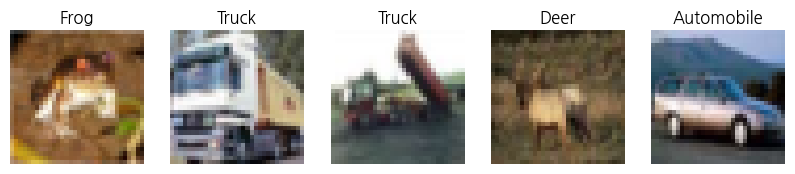

In [6]:
# CIFAR-10 클래스 이름
class_names = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer",
    "Dog", "Frog", "Horse", "Ship", "Truck"
]

# 이미지와 라벨 확인
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train[i])
    plt.title(class_names[y_train[i][0]])  # 라벨을 클래스 이름으로 변환
    plt.axis('off')
plt.show()

### 데이터 분포 확인

Airplane: 5000개
Automobile: 5000개
Bird: 5000개
Cat: 5000개
Deer: 5000개
Dog: 5000개
Frog: 5000개
Horse: 5000개
Ship: 5000개
Truck: 5000개


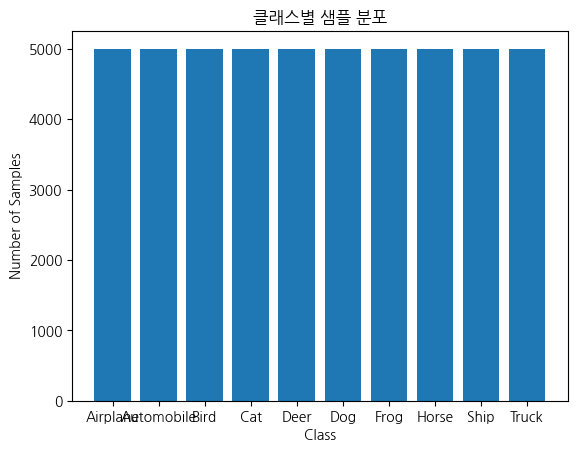

In [7]:
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    print(f"{class_names[label]}: {count}개")

# 시각화 (막대그래프)
plt.bar(unique, counts, tick_label=class_names)
plt.title("클래스별 샘플 분포")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

위와 같이 데이터들이 5000개씩 고르게 분포되어있는 것을 확인 가능함.


### 데이터 특성 확인

픽셀 최소값: 0
픽셀 최대값: 255
훈련 데이터 평균: 120.70756512369792
훈련 데이터 표준편차: 64.1500758911213


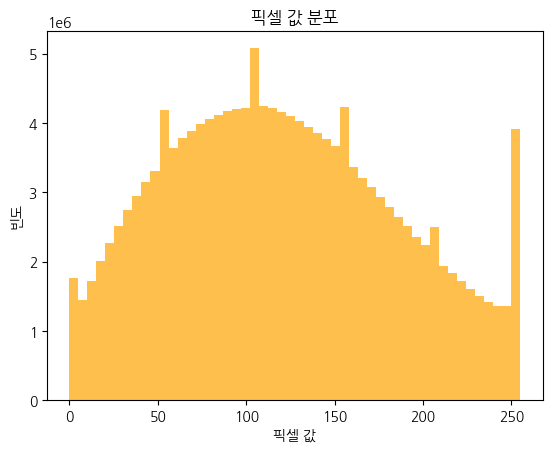

In [8]:
# 데이터 범위
print("픽셀 최소값:", X_train.min())
print("픽셀 최대값:", X_train.max())

# 픽셀 값의 평균과 표준편차
print("훈련 데이터 평균:", X_train.mean())
print("훈련 데이터 표준편차:", X_train.std())

# 히스토그램을 통한 픽셀 값 분포 시각화
plt.hist(X_train.ravel(), bins=50, color='orange', alpha=0.7)
plt.title("픽셀 값 분포")
plt.xlabel("픽셀 값")
plt.ylabel("빈도")
plt.show()

해당 데이터셋은 0부터 255까지의 RGB값으로 구성되어있는 데이터임을 확인했고, 해당 데이터의 학습을위해
0부터 1사이의 값으로 정규화를 진행하는 것이 효율적이다.

### 데이터 백업 혹은 복사

원본 데이터의 변경 및 손실 방지를 위해 데이터를 복사한다.

In [9]:
X_train_df = X_train.copy()
X_test_df = X_test.copy()
y_train_df = y_train.copy()
y_test_df = y_test.copy()
print("훈련 데이터 크기:", X_train_df.shape)
print("훈련 레이블 크기:", y_train_df.shape)
print("테스트 데이터 크기:", X_test_df.shape)
print("테스트 레이블 크기:", y_test_df.shape)

훈련 데이터 크기: (50000, 32, 32, 3)
훈련 레이블 크기: (50000, 1)
테스트 데이터 크기: (10000, 32, 32, 3)
테스트 레이블 크기: (10000, 1)


In [10]:
# 채널별 평균 계산
channel_means = np.mean(X_train_df, axis=(0, 1, 2))  # 채널(RGB)을 제외한 나머지 차원에 대해 평균 계산
channel_stds = np.std(X_train_df, axis=(0, 1, 2))    # 채널(RGB)을 제외한 나머지 차원에 대해 표준편차 계산

print("채널별 평균:", channel_means)
print("채널별 표준편차:", channel_stds)

채널별 평균: [125.30691805 122.95039414 113.86538318]
채널별 표준편차: [62.99321928 62.08870764 66.70489964]


In [11]:
# 데이터 정규화 // 표준 정규분포로 정규화하기
X_train_df = (X_train_df - channel_means) / channel_stds
X_test_df = (X_test_df - channel_means) / channel_stds

# 채널별 평균 및 표준편차 확인
print("채널별 평균 (정규화 후):", X_train_df.mean(axis=(0, 1, 2)))
print("채널별 표준편차 (정규화 후):", X_train_df.std(axis=(0, 1, 2)))

채널별 평균 (정규화 후): [ 6.57175263e-15  1.42758541e-13 -3.32364019e-15]
채널별 표준편차 (정규화 후): [1. 1. 1.]


데이터가 평균0 표준편차 1로 잘 정규화됨.

정규화된 이미지 확인

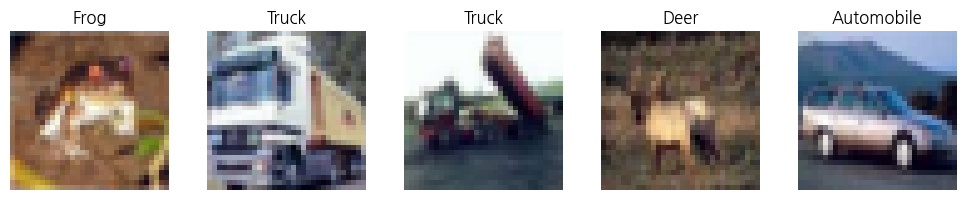

In [37]:
plt.figure(figsize=(10, 2))

for i in range(5):
    plt.subplot(1, 5, i + 1)

    # 이미지 데이터 값 정규화
    img = X_train_df[i]

    # 데이터가 float 타입일 경우 0~1로, int 타입일 경우 0~255로 변환
    if img.dtype != np.uint8:  # uint8이 아니면 변환 필요
        img = (img - img.min()) / (img.max() - img.min())  # 0~1로 정규화
        img = (img * 255).astype(np.uint8)  # 0~255 범위로 변환

    plt.imshow(img)  # 정규화된 이미지를 출력
    plt.title(class_names[y_train[i][0]])  # 클래스 이름 출력
    plt.axis('off')  # 축 숨기기

plt.tight_layout()  # 레이아웃 정리
plt.show()

In [13]:
# One-Hot Encoding
from tensorflow.keras.utils import to_categorical

Y_train = to_categorical(y_train_df, 10)
Y_test = to_categorical(y_test_df, 10)

### 데이터셋 분할

훈련 데이터를 학습용과 검증용으로 나눠 과적합 방지

In [14]:
from sklearn.model_selection import train_test_split

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_df, y_train_df, test_size=0.2, random_state=42)

print("훈련 데이터 크기:", X_train_split.shape)
print("검증 데이터 크기:", X_val_split.shape)
print("테스트 데이터 크기", X_val_split.shape)
print(y_test_df.shape)

훈련 데이터 크기: (40000, 32, 32, 3)
검증 데이터 크기: (10000, 32, 32, 3)
테스트 데이터 크기 (10000, 32, 32, 3)
(10000, 1)


## 모델 구축 및 훈련

* MLP

In [15]:
from keras import Input,models, layers

# MLP 모델 구축
model_mlp = models.Sequential([
    Input(shape=(32, 32, 3)),  # 명시적으로 입력 정의
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),     # 첫 번째 은닉층
    layers.Dense(512, activation='relu'),     # 두 번째 은닉층
    layers.Dense(512, activation='relu'),     # 세 번째 은닉층
    layers.Dense(10, activation='softmax')    # 출력층 (10개의 클래스)
])
# 모델 요약
model_mlp.summary()
# 모델 컴파일
model_mlp.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 훈련
with tf.device('/GPU:0'):  # GPU를 명시적으로 지정
    history_mlp = model_mlp.fit(X_train_split, y_train_split,
                        epochs=10,
                        validation_data=(X_val_split, y_val_split))

# 모델 평가
test_loss, test_acc = model_mlp.evaluate(X_test_df, y_test_df)
print(f"테스트 정확도: {test_acc * 100:.2f}%")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       3,146,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,939,338 (15.03 MB)

 Trainable params: 3,939,338 (15.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.3287 - loss: 1.9694 - val_accuracy: 0.4297 - val_loss: 1.6345
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4464 - loss: 1.5729 - val_accuracy: 0.4554 - val_loss: 1.5471
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4843 - loss: 1.4579 - val_accuracy: 0.4683 - val_loss: 1.5062
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5126 - loss: 1.3863 - val_accuracy: 0.4721 - val_loss: 1.5120
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5390 - loss: 1.3133 - val_accuracy: 0.4830 - val_loss: 1.5013
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5582 - loss: 1.2442 - val_accuracy: 0.4940 - val_loss: 1.4724
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5814 - loss: 1.1854 - val_accuracy: 0.5027 - val_loss: 1.5172
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6018 - loss: 1.1202 -

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


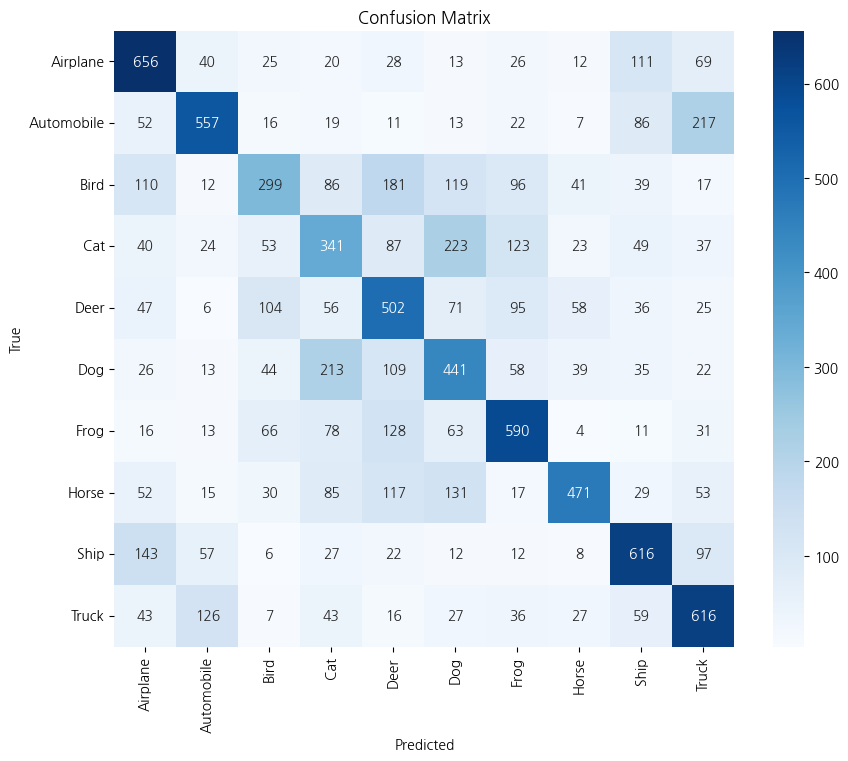

In [16]:
from sklearn.metrics import confusion_matrix
# 모델 예측
y_pred = model_mlp.predict(X_test_df)
y_pred_classes = np.argmax(y_pred, axis=1)  # 예측된 클래스 (가장 높은 확률을 가진 클래스)

# 혼동 행렬 계산
cm = confusion_matrix(y_test_df, y_pred_classes)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

해당 데이터셋에서 유난히 고양이와 개에 관한 혼동을 하고있고, 새에 대한 분류는 제대로 되고 있지 않음을 알 수 있다.

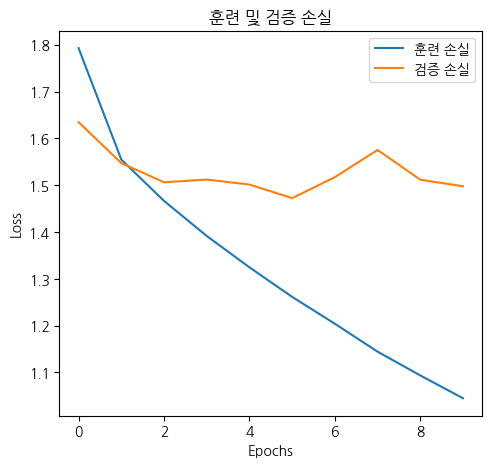

In [17]:
# 손실률과 정확도 시각화
plt.figure(figsize=(12, 5))

# 손실률
plt.subplot(1, 2, 1)
plt.plot(history_mlp.history['loss'], label='훈련 손실')
plt.plot(history_mlp.history['val_loss'], label='검증 손실')
plt.title('훈련 및 검증 손실')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


해당 데이터셋은 검증손실과 훈련손실 그래프의 특성으로만 보면 과대적합 되어있을 확률이 높다. 해당 데이터셋에서의 정확도도 높지 않은데 해당 해석이 나왔음은 의문이다.

* CNN

In [18]:
# CNN 모델 정의
model_cnn = models.Sequential([
    # 첫 번째 Convolutional Layer
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),

    # 두 번째 Convolutional Layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # 세 번째 Convolutional Layer
    layers.Conv2D(64, (3, 3), activation='relu'),

    # Flatten Layer
    layers.Flatten(),

    # Fully Connected (Dense) Layer
    layers.Dense(64, activation='relu'),

    # 출력층 (10개의 클래스)
    layers.Dense(10, activation='softmax')
])

# 모델 요약
model_cnn.summary()

# 모델 컴파일
model_cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 훈련
with tf.device('/GPU:0'):  # GPU를 명시적으로 지정
    history_cnn = model_cnn.fit(X_train_split, y_train_split,
                        epochs=10,
                        validation_data=(X_val_split, y_val_split))
# 모델 평가
test_loss, test_acc = model_cnn.evaluate(X_test_df, y_test_df)
print(f"테스트 정확도: {test_acc * 100:.2f}%")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.3809 - loss: 1.6903 - val_accuracy: 0.5904 - val_loss: 1.1464
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6035 - loss: 1.1091 - val_accuracy: 0.6581 - val_loss: 0.9981
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6847 - loss: 0.8995 - val_accuracy: 0.6790 - val_loss: 0.9271
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7247 - loss: 0.7997 - val_accuracy: 0.7009 - val_loss: 0.8703
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7520 - loss: 0.7079 - val_accuracy: 0.7074 - val_loss: 0.8570
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7727 - loss: 0.6463 - val_accuracy: 0.7133 - val_loss: 0.8514
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7919 - loss: 0.5900 - val_accuracy: 0.7225 - val_loss: 0.8271
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8104 - loss: 0.5338 - 

#### 손실률의 시각화 및 정확도, 혼동행렬

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


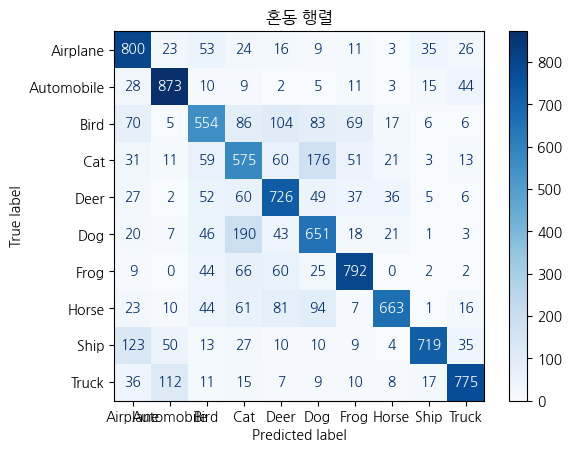

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#혼동 행렬 (Confusion Matrix)
y_pred = model_cnn.predict(X_test_df)
y_pred_classes = np.argmax(y_pred, axis=1)  # 예측된 클래스를 가져오기 위해 argmax 사용

cm = confusion_matrix(y_test_df, y_pred_classes)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# 혼동 행렬 시각화
cm_display.plot(cmap=plt.cm.Blues)
plt.title("혼동 행렬")
plt.show()




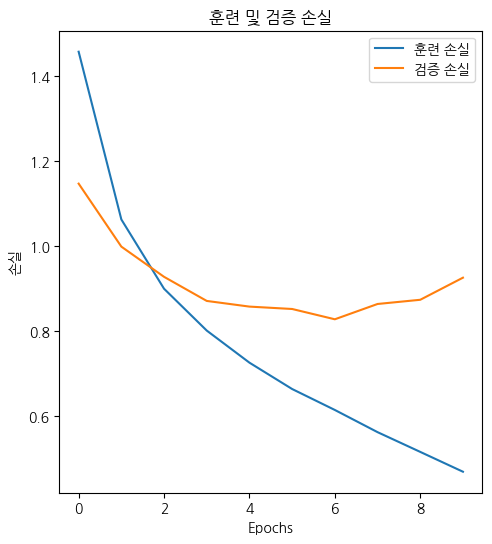

In [20]:
# 학습 손실 그래프
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='훈련 손실')
plt.plot(history_cnn.history['val_loss'], label='검증 손실')
plt.title('훈련 및 검증 손실')
plt.xlabel('Epochs')
plt.ylabel('손실')
plt.legend()

해당 데이터셋은 6에폭을 기점으로 감소하다가 다시 증가함을 보면, 과대적합되어있음을 알 수 있다.

* 학습한 cnn모델의 결과를 예측한후 이 예측값을 토대로 다른 모델의 입력값으로 사용한다.

In [21]:
# CNN 모델을 훈련시킨 후 예측값 얻기
cnn_predictions = model_cnn.predict(X_train_split)
cnn_pred_labels = np.argmax(cnn_predictions, axis=1)  # 클래스 예측 (최대 확률인 인덱스)

# CNN 예측 결과 출력 (예: 클래스 레이블)
print("CNN 예측 레이블 (첫 5개):", cnn_pred_labels[:5])

# CNN 예측 결과를 다른 모델의 학습 데이터로 사용
X_train_cnn = cnn_pred_labels.reshape(-1, 1)  # 1D로 변환
y_train_cnn = y_train_split

# 훈련/테스트 데이터 분할
X_train_cnn_split, X_val_cnn_split, y_train_cnn_split, y_val_cnn_split = train_test_split(X_train_cnn, y_train_cnn, test_size=0.2, random_state=42)


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
CNN 예측 레이블 (첫 5개): [6 2 5 6 3]


In [22]:
from sklearn.metrics import confusion_matrix
# 혼동행렬 구하기 위한 함수
def plot_confusion_matrix(cm, labels, title="Confusion Matrix"):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


* CNN+KNN

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# 1. KNN 모델
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_cnn_split, y_train_cnn_split)
knn_pred = knn.predict(X_val_cnn_split)
knn_acc = accuracy_score(y_val_cnn_split, knn_pred)
print(f"KNN 정확도: {knn_acc * 100:.2f}%")


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNN 정확도: 86.22%


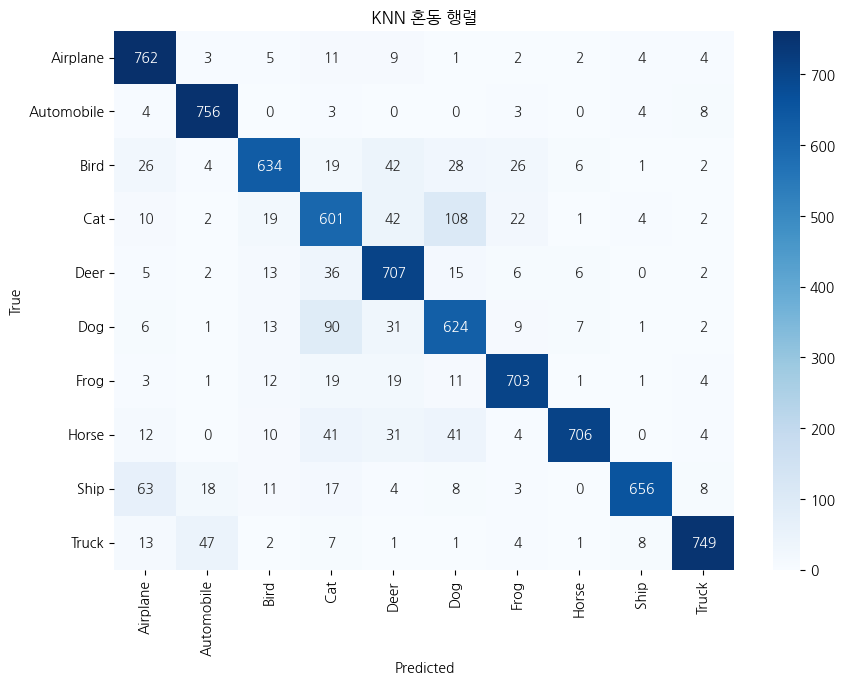

In [24]:
# 1. KNN 혼동 행렬
knn_cm = confusion_matrix(y_val_cnn_split, knn_pred)
plot_confusion_matrix(knn_cm, class_names, "KNN 혼동 행렬")


과도하게 해당 데이터에 대한 정확도가 높다. 과대적합일 확률이 농후하다.

* CNN+SVM

In [25]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train_cnn_split, y_train_cnn_split)
svm_pred = svm.predict(X_val_cnn_split)
svm_acc = accuracy_score(y_val_cnn_split, svm_pred)
print(f"SVM 정확도: {svm_acc * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM 정확도: 86.22%


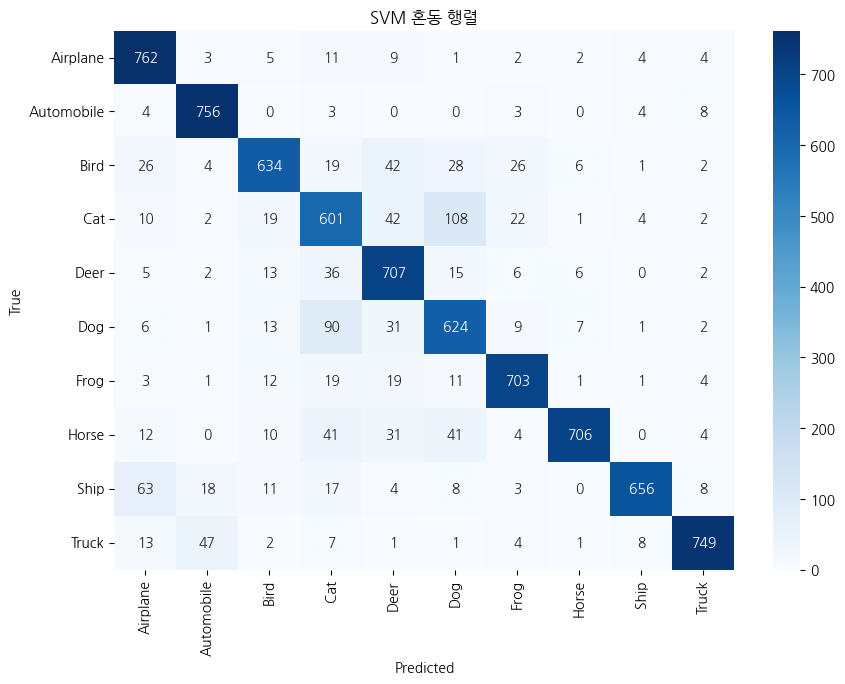

In [26]:
svm_cm = confusion_matrix(y_val_cnn_split, svm_pred)
plot_confusion_matrix(svm_cm, class_names, "SVM 혼동 행렬")

과도하게 해당 데이터에 대한 정확도가 높다. 과대적합일 확률이 농후하다. 다만 아직도 개와 고양이에 대한 오차가 높음은 확인 가능하다.

* CNN+DT

In [27]:
from sklearn.tree import DecisionTreeClassifier

# 3. Decision Tree 모델
dt = DecisionTreeClassifier()
dt.fit(X_train_cnn_split, y_train_cnn_split)
dt_pred = dt.predict(X_val_cnn_split)
dt_acc = accuracy_score(y_val_cnn_split, dt_pred)
print(f"DecisionTree 정확도: {dt_acc * 100:.2f}%")

DecisionTree 정확도: 86.22%


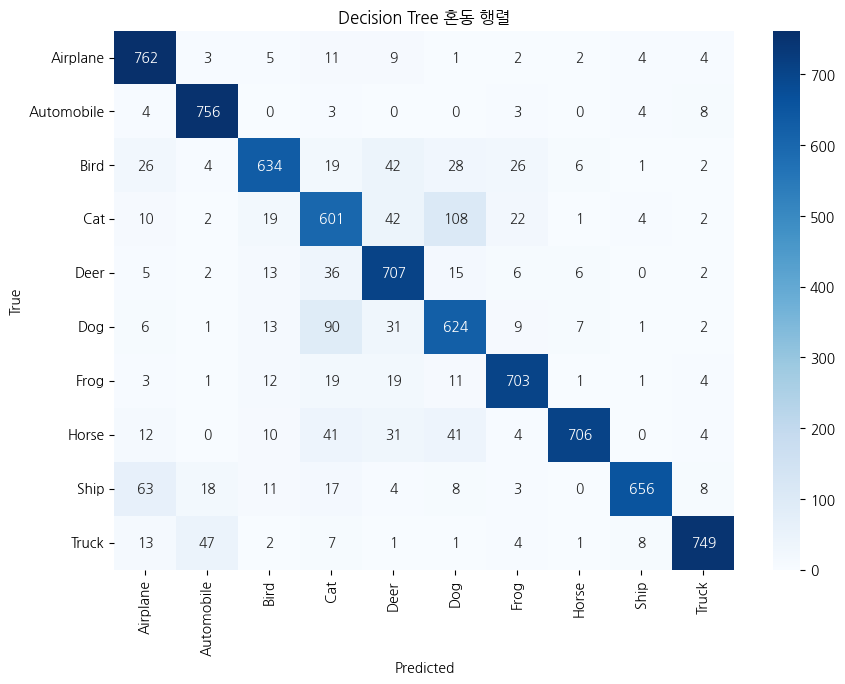

In [28]:
dt_cm = confusion_matrix(y_val_cnn_split, dt_pred)
plot_confusion_matrix(dt_cm, class_names, "Decision Tree 혼동 행렬")

해당 혼동행렬도 위의 혼동행렬들과 비슷한 흐름을 보인다. 개와 고양이에 대한 분류가 제대로 이루어지지 않으며, 트럭과 차에 대한 분류도 비슷하게 흘러간다.

* CNN + MLP

In [29]:
model_CNN_MLP = keras.models.Sequential([
    # 첫 번째 Conv2D 레이어
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2), strides=2),

    # 두 번째 Conv2D 레이어
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), strides=2),

    # 세 번째 Conv2D 레이어
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), strides=2),

    # 평탄화 레이어
    layers.Flatten(),

    # MLP Dense 레이어
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10개의 클래스 출력
])
# 모델 요약
model_CNN_MLP.summary()

# 모델 컴파일
model_CNN_MLP.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

history = model_CNN_MLP.fit(X_train_split, y_train_split,
                            epochs=10,
                            validation_data=(X_val_split, y_val_split))
# 모델 평가
test_loss, test_acc = model_CNN_MLP.evaluate(X_test_df, y_test_df)
print(f"테스트 정확도: {test_acc * 100:.2f}%")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 364,426 (1.39 MB)

 Trainable params: 364,426 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.4031 - loss: 1.6259 - val_accuracy: 0.6294 - val_loss: 1.0422
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6697 - loss: 0.9357 - val_accuracy: 0.6965 - val_loss: 0.8619
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7478 - loss: 0.7251 - val_accuracy: 0.7320 - val_loss: 0.7778
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7927 - loss: 0.5902 - val_accuracy: 0.7458 - val_loss: 0.7542
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8236 - loss: 0.4948 - val_accuracy: 0.7517 - val_loss: 0.7529
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8578 - loss: 0.4064 - val_accuracy: 0.7465 - val_loss: 0.8273
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8867 - loss: 0.3186 - val_accuracy: 0.7452 - val_loss: 0.8269
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9100 - loss: 0.2569 - 

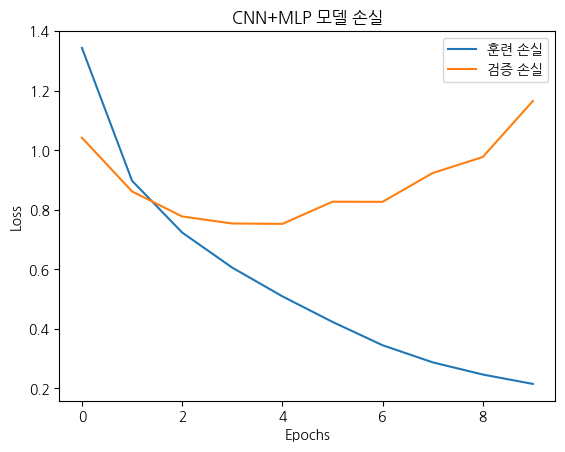

In [30]:
# 손실 그래프
plt.plot(history.history['loss'], label='훈련 손실')
plt.plot(history.history['val_loss'], label='검증 손실')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN+MLP 모델 손실')
plt.legend()
plt.show()

방금 cnn과 같이 해당 모델은 4에폭을 기점으로 손실률이 다시 올라간다. 해당 모델은 과대적합 되어있다.

* 모델의 정확도를 올리기 위해서 드랍아웃 추가, 데이터 증강(DataAugmentation), 레이어 추가 등 여러 방법을 모색해본다.  
모델의 정확도가 높지않아 새로운 방법으로 VGG16을 적용해본다.

In [31]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# 1. VGG16 사전 학습 모델 로드 (include_top=False로 Fully Connected Layer 제외)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
# 일부 레이어 Fine-tuning 활성화 (마지막 4개 레이어 훈련 가능)
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

# 2. 새로운 커스텀 레이어 추가
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # 드롭아웃 비율 유지
output = Dense(10, activation='softmax')(x)

# 최종 모델 정의
model_VGG = Model(inputs=base_model.input, outputs=output)
model_VGG.summary()

# 3. 콜백 정의
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint('./best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# 4. 모델 컴파일
model_VGG.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 5. 데이터 증강
datagen = ImageDataGenerator(
    rotation_range=20,         # 더 강한 회전 각도
    width_shift_range=0.2,     # 가로 이동 범위 증가
    height_shift_range=0.2,    # 세로 이동 범위 증가
    shear_range=0.2,           # 기울기 범위 증가
    zoom_range=0.2,            # 확대/축소 범위 증가
    horizontal_flip=True,      # 좌우 반전 유지
    fill_mode='nearest',
    brightness_range=[0.8, 1.2] # 밝기 조정 추가
)
datagen.fit(X_train_split)

# 6. 모델 훈련
history = model_VGG.fit(
    datagen.flow(X_train_split, y_train_split, batch_size=32),
    epochs=10,
    validation_data=(X_val_split, y_val_split),
    callbacks=[lr_scheduler, checkpoint, early_stop]  # 모든 콜백 추가
)

# 7. 모델 평가
test_loss, test_acc = model_VGG.evaluate(X_test_df, y_test_df)
print(f"테스트 정확도: {test_acc * 100:.2f}%")

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,849,610 (56.65 MB)

 Trainable params: 7,213,834 (27.52 MB)

 Non-trainable params: 7,635,776 (29.13 MB)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 48s 34ms/step - accuracy: 0.4391 - loss: 1.6118 - val_accuracy: 0.6853 - val_loss: 0.9184 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.6166 - loss: 1.1149 - val_accuracy: 0.6653 - val_loss: 0.9877 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - accuracy: 0.6500 - loss: 1.0352 - val_accuracy: 0.7158 - val_loss: 0.8268 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.6550 - loss: 1.0318 - val_accuracy: 0.7404 - val_loss: 0.8033 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.6745 - loss: 0.9681 - val_accuracy: 0.6744 - val_loss: 0.9922 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.6830 - loss: 0.9474 - val_accuracy: 0.7534 - val_loss: 0.7220 - learning_rate: 0.0010
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.6968 

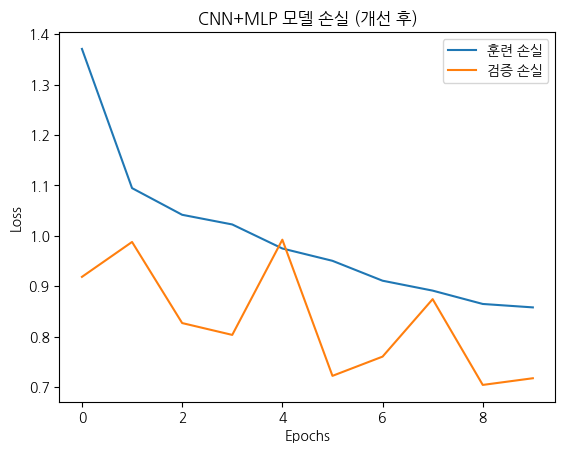

In [32]:
# 손실 그래프
plt.plot(history.history['loss'], label='훈련 손실')
plt.plot(history.history['val_loss'], label='검증 손실')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN+MLP 모델 손실 (개선 후)')
plt.legend()
plt.show()

해당 그래프를 해석할때 진동 폭이 너무 큰 것을 알 수 있다. 해당 모델을 개선하기 위해서는 배치의 수를 늘려주는 것이 필요하다. 하지만 학습을 진행할수록 감소하는 경향을 가지고 있다.

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


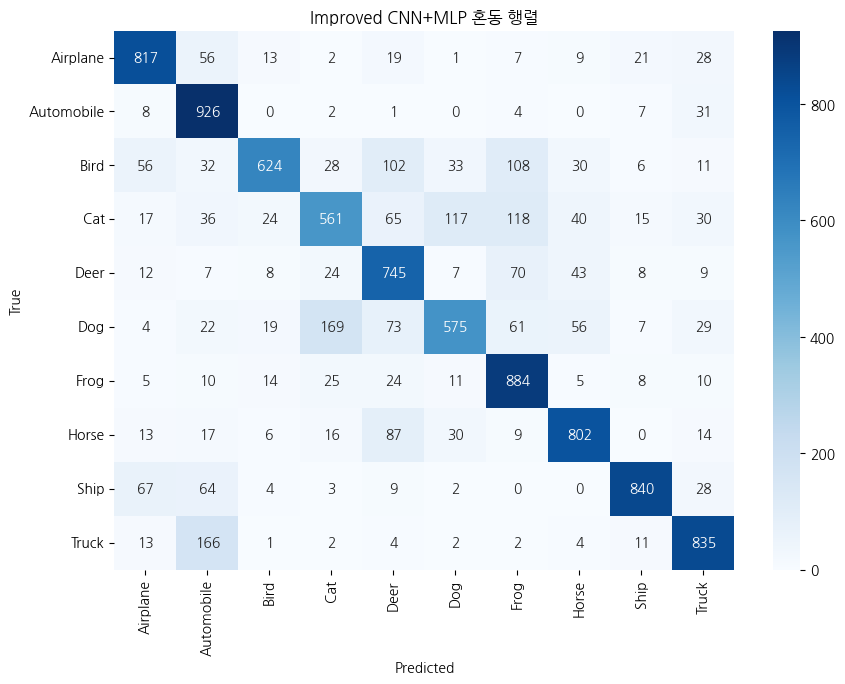

In [33]:
# 예측
y_pred_improved = model_VGG.predict(X_val_split)
y_pred_labels = np.argmax(y_pred_improved, axis=1)  # 예측된 클래스 레이블

# 혼동 행렬 생성
cm_improved = confusion_matrix(y_val_split, y_pred_labels)

plot_confusion_matrix(cm_improved, class_names, "Improved CNN+MLP 혼동 행렬")

해당 혼동행렬에서 최종적으로 알 수 있는점은, 개와 고양이, 차와 트럭같이 특성이 비슷한 데이터들은 분류를 잘 못하고있다.

## 결론 및 고찰

해당 데이터셋은 어떤 객체를 구별할지 결정하는 모델을 구성할때 유용한 데이터셋이라고 판단된다. 해당 모델에 대한 코드를 짜면서, 수업시간에 최적화 기법에 대해 왜 설명하셨는지도 이해가 갔다. 상위의 모델들을 학습하면서 느끼는 것이, 데이터 양이 턱없이 부족해보인다는 것이었다. 해당 모델들을 앙상블하면서 정확도는 늘리는것이 가능했지만, 과대적합과 같은 현상들은 해결하기가 어려웠다. 분류라는 측면에서의 데이터셋 분석이 무의미해지는 것 같았다. 따라서 해당 데이터들의 최적화와 어떻게하면 특징을 잡아 훨씬 더 많은 데이터를 처리할 수 있는지가 더더욱 중요하다고 느꼈다.

해당 데이터셋을 분석하고 모델을 학습하던 중, 이상한 점이 발견되었다. CUDA가 작동하지 않아. 해당 문제를 해결하는데 가장 많은 시간을 허비했던 것 같다. 3060이 아닌 3060LAPTOP은 다른 버전을 써야하는지, 파이썬 버전을 다운그레이드도 해보면서 문제를 해결했던 것 같다. 이번 실습을 토대로 이전에 수업때 왜 GPU설정할때 스트레스가 받는다고 하셨는지 뼈저리게 느꼈다.